# GHSL

## Extract GHSL population for Sao Paulo (Brazil)

In [1]:
from IPython.display import display_markdown

display_markdown(open("README.md").read(), raw=True)

# GHSL extract

This dataset contains an extract from the 2015 [GHSL Pop](https://ghsl.jrc.ec.europa.eu/ghs_pop.php) for the area of Sao Paulo (Brazil). 

Boundary delineation for the urban area relies on the [Functional Urban Areas](https://ec.europa.eu/jrc/en/publication/ghsl-oecd-functional-urban-areas) by the GHSL-OECD.

- `Source`: European Commission
- `URL`:

> [https://ghsl.jrc.ec.europa.eu/ghs_pop.php](https://ghsl.jrc.ec.europa.eu/ghs_pop.php)

- `Processing`: Generation of the dataset is documented in `build_ghsl_extract.ipynb`



In [2]:
import geopandas
import rioxarray
import contextily
import datashader as ds
import matplotlib.pyplot as plt

## Functional Urban Area boundary

The file with all the FUAs is available at:

In [3]:
url = ("https://jeodpp.jrc.ec.europa.eu/ftp/"\
       "jrc-opendata/GHSL/"\
       "GHS_FUA_UCDB2015_GLOBE_R2019A/V1-0/"\
       "GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.zip"
      )
url

'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_FUA_UCDB2015_GLOBE_R2019A/V1-0/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.zip'

From there we can build a path to read and uncompress directly on-the-fly in `geopandas`:

In [4]:
p = f"zip+{url}!GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg"
fuas = geopandas.read_file(p)
sao_paulo = fuas.query("eFUA_name == 'São Paulo'").to_crs("EPSG:4326")

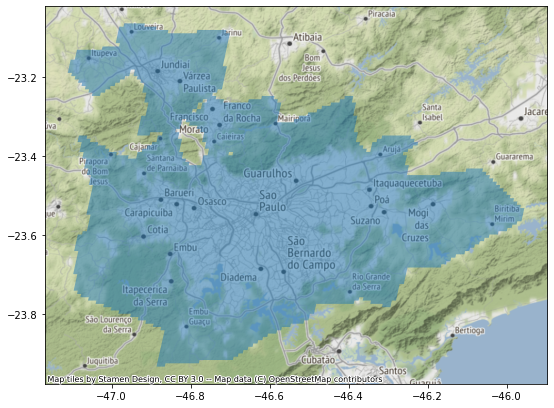

In [5]:
ax = sao_paulo.plot(alpha=0.5, figsize=(9, 9))
contextily.add_basemap(ax, crs=sao_paulo.crs);

## Population layer

The file for the tile we need is available for download at:

In [6]:
url = ("https://cidportal.jrc.ec.europa.eu/ftp/"\
       "jrc-opendata/GHSL/GHS_POP_MT_GLOBE_R2019A/"\
       "GHS_POP_E2015_GLOBE_R2019A_54009_250/V1-0/"\
       "tiles/"\
       "GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0_13_11.zip"
      )
url

'https://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_MT_GLOBE_R2019A/GHS_POP_E2015_GLOBE_R2019A_54009_250/V1-0/tiles/GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0_13_11.zip'

From there we can build a path to read and uncompress directly on-the-fly in `xarray`:

In [7]:
%%time
p = f"zip+{url}!GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0_13_11.tif"
ghsl = rioxarray.open_rasterio(p)
ghsl

CPU times: user 40.6 ms, sys: 3.2 ms, total: 43.8 ms
Wall time: 4.56 s


<xarray.DataArray (band: 1, y: 4000, x: 4000)>
[16000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 -2e+06 -2e+06 -2.001e+06 ... -3e+06 -3e+06
  * x            (x) float64 -5.041e+06 -5.041e+06 ... -4.041e+06 -4.041e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -200.0
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [8]:
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.raster(ghsl.where(ghsl>0).sel(band=1))

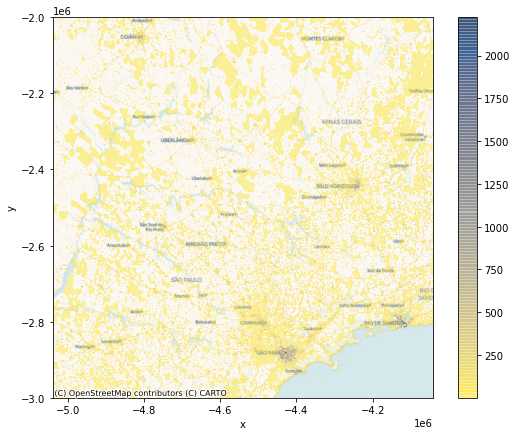

In [9]:
f, ax = plt.subplots(1, figsize=(9, 7))
agg.plot.imshow(ax=ax, alpha=0.5, cmap="cividis_r")
contextily.add_basemap(
    ax, 
    crs=ghsl.rio.crs, 
    zorder=-1, 
    source=contextily.providers.CartoDB.Voyager
)

## Extraction

To clip what we need from `ghsl` based on `sao_paulo`, we can clip it:

In [10]:
ghsl_sp = ghsl.rio.clip(sao_paulo.to_crs(ghsl.rio.crs).geometry.iloc[0])
ghsl_sp

<xarray.DataArray (band: 1, y: 416, x: 468)>
array([[[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
  * x            (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref
    _FillValue:    -200.0

And we can write it to a GeoTIF file:

In [11]:
out_p = "ghsl_sao_paulo.tif"
! rm $out_p
ghsl_sp.rio.to_raster(out_p)

From `rioxarray` we get a COG for free!

In [12]:
! rio cogeo validate ghsl_sao_paulo.tif

/home/jovyan/work/data/ghsl/ghsl_sao_paulo.tif is a valid cloud optimized GeoTIFF


---

## Download link

{download}`[Download the *ghsl_sao_paulo.tif* file] <ghsl_sao_paulo.tif>`